<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

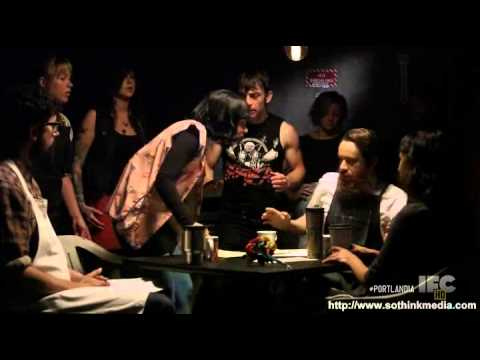

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

# Imports

In [2]:
import pandas as pd
import seaborn as sns

import squarify
import matplotlib.pyplot as plt

import spacy
from spacy.tokenizer import Tokenizer
import re
from collections import Counter

nlp = spacy.load("en_core_web_lg")

# Load data

In [3]:
path = "data/yelp_coffeeshop_review_data.csv"

df = pd.read_csv(path)
df.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


# Cleaning

In [4]:
df.rename(columns={"coffee_shop_name": "shop", "full_review_text": "review", "star_rating": "rating"}, inplace=True)

df.rating = df.rating.str.strip(" star rating")
df.rating = pd.to_numeric(df.rating)

In [5]:
def split_date(cell):
    return cell.strip().split()[0]

In [6]:
def tokenize(text):
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()
    return " ".join(tokens[2:])

In [7]:
df['date'] = df['review'].apply(split_date)
df['date'] = pd.to_datetime(df.date)
df['review'] = df['review'].apply(tokenize)

In [8]:
df.head()

,shop,review,rating,date
0,The Factory - Cafe With a Soul,checkin love love loved the atmosphere every c...,5.0,2016-11-25
1,The Factory - Cafe With a Soul,in date night austin ambiance in austin beauti...,4.0,2016-12-02
2,The Factory - Cafe With a Soul,checkin listed in brunch spots i loved the ecl...,4.0,2016-11-30
3,The Factory - Cafe With a Soul,cool decor good drinks nice seating however ju...,2.0,2016-11-25
4,The Factory - Cafe With a Soul,checkin they are located within the northcross...,4.0,2016-12-03


5.0    0.496324
4.0    0.309874
3.0    0.096901
2.0    0.060399
1.0    0.036502
Name: rating, dtype: float64

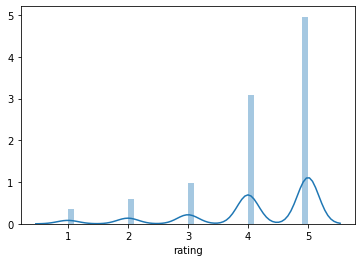

In [9]:
sns.distplot(df.rating);

df.rating.value_counts(normalize=True)

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [10]:
# what are the most frequent words for good shops
good = df[df.rating >= 4].copy()
bad = df[df.rating < 4].copy()

In [11]:
# tokenizer = Tokenizer(nlp.vocab)

In [55]:
stop = nlp.Defaults.stop_words.union(['coffee', 'latte'])
def get_lemmas(text):
    lemmas = []
    doc = nlp(text)
    for token in doc: 
        if ((token.text.lower() not in stop) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    return lemmas

In [56]:
def count(docs):
        word_counts = Counter()
        appears_in = Counter()
        total_docs = len(docs)
        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))
        temp = zip(word_counts.keys(), word_counts.values())
        wc = pd.DataFrame(temp, columns = ['word', 'count'])
        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()
        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()
        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')
        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        return wc.sort_values(by='rank')

In [57]:
good['lemmas'] = good.review.apply(get_lemmas)
bad['lemmas'] = bad.review.apply(get_lemmas)

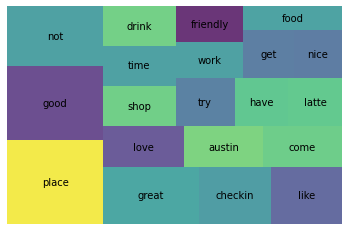

In [183]:
wc1 = count(good['lemmas'])
wc_top20 = wc1[wc1['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

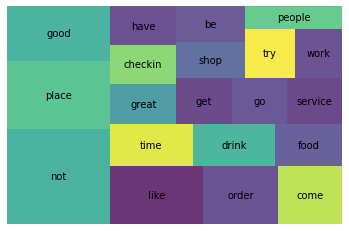

In [184]:
wc2 = count(bad['lemmas'])
wc_top20 = wc2[wc2['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [185]:
good.head(1)

,shop,review,rating,date,lemmas
0,The Factory - Cafe With a Soul,checkin love love loved the atmosphere every c...,5.0,2016-11-25,"[checkin, love, love, love, atmosphere, corner..."


In [186]:
wc1.reset_index(inplace=True)
wc2.reset_index(inplace=True)

In [187]:
wc1.head()

,index,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
0,113,place,3130,4812,1.0,0.017575,0.017575,0.509772
1,170,good,2869,4270,2.0,0.015596,0.033171,0.467264
2,132,not,2185,3465,3.0,0.012656,0.045826,0.355863
3,64,great,2369,3271,4.0,0.011947,0.057773,0.385831
4,10,checkin,2441,2454,5.0,0.008963,0.066736,0.397557


In [188]:
wc2.head()

,index,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
0,151,not,864,1697,1.0,0.021740,0.021740,0.585366
1,32,place,754,1227,2.0,0.015719,0.037458,0.510840
2,8,good,634,979,3.0,0.012542,0.050000,0.429539
3,4,like,590,935,4.0,0.011978,0.061978,0.399729
4,139,order,430,756,5.0,0.009685,0.071663,0.291328


In [137]:
import numpy as np
biggest_diff = []
_ = list(wc1.word)
for i, j in  enumerate(wc2.word):
    if j in _:
        biggest_diff.append((j, wc2['appears_in_pct'][i] - (wc1[wc1.word == j]['appears_in_pct'].values[0])))

In [152]:
biggest_diff[:10]

[('not', 0.22950266147612614),
 ('great', -0.1541233018193374),
 ('delicious', -0.1333695258776692),
 ('like', 0.12823062595446805),
 ('order', 0.1263441999240839),
 ('love', -0.1086681143684401),
 ('friendly', -0.10587290237723224),
 ('ask', 0.09840002471685955),
 ('checkin', -0.0913239409267057),
 ('service', 0.09063893081927563)]

/home/allan/.local/share/virtualenvs/u4-s1-1fz81KSO/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


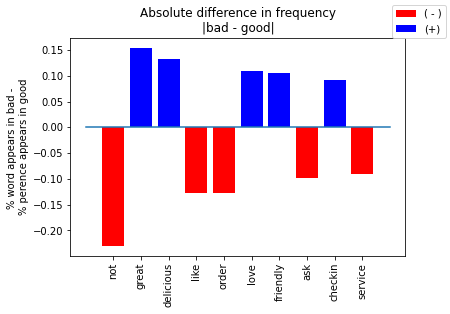

In [190]:
fig, ax = plt.subplots()

ax.bar([1,4,5,8,10], height=[-1 * i[-1] for i in biggest_diff[:10] if i[-1] > 0], color='r', label='( - )')
ax.bar([2,3,6,7,9], height=[-1 * i[-1] for i in biggest_diff[:10] if i[-1] < 0], color='b', label='(+)')
ax.set_xticks(range(1, 11))
ax.set_xticklabels([i[0] for i in biggest_diff[:10]], rotation='vertical')
ax.plot(range(12), [0]*12)

ax.set_title("Absolute difference in frequency\n|bad - good|")
ax.set_ylabel("% word appears in bad - \n% perence appears in good")

fig.legend()
fig.show()

In [145]:
# + appears more in bad
# - appears more in good

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

